# Vectorization and Feature Engineering

So far in this course, we've considered the general *supervised learning* scenario, in which we are given a feature matrix $\mathbf{X} \in \mathbb{R}^{n\times p}$ and a target vector $\mathbf{y} \in \mathbb{R}^n$. We then solve the empirical risk minimization problem in order to choose model parameters that minimize a loss function on the training data. The exact structure of this loss function depends on things like whether we are doing classification or regression, what our computational resources are, and other considerations. 

But feature matrices $\mathbf{X}$ and target vectors $\mathbf{y}$ don't just exist in the world: they are *collected* and *measured*. We can think of data collection and measurement as posing three fundamental questions: 

- **Data collection**: Which **rows** (observations) exist in $\mathbf{X}$ and $\mathbf{y}$? 
- **Measurement**: which **columns** (features) exist in $\mathbf{X}$? 
- **Measurement**: what is the **target** $\mathbf{y}$ and how is it measured? 

Broadly, we can think of the complete machine learning workflow as having phases corresponding to problem definition, data collection + measurement, modeling, and evaluation. Here's roughly how this looks: 

```{mermaid}
flowchart TB

    subgraph problem[problem definition]
        need[identify need]-->design_collection[design data collection]
    end
    subgraph measurement[data collection + measurement]
        training[training data] 
        testing[testing data]
    end
    subgraph modeling
        explore[explore data] --> engineer[engineer features]
        engineer --> design[design model]
    end
    subgraph assessment
        test --> audit
        audit --> deploy
        deploy-->evaluate
    end
    design_collection-->measurement
    training --vectorization--> modeling
    design --> assessment
    testing --vectorization--> assessment
    need-->assessment

```

So far, we've spent most of our time in the "modeling" module, especially the last two steps. We've also studied some of the ways to test and audit algorithms, especially with regards to questions of fairness and equity. Today we're going to discuss **vectorization**. We can think of vectorization as what happens *between* the collection of raw data and the use of that data as input for machine learning models.  

::: {.callout-note}

::: {#def-vectorization}

## Vectorization

**Vectorization** is the act of assigning to each data observation a vector $\mathbf{x}$, thus forming a feature matrix $\mathbf{X}$. Formally, a **vectorization map** is a function $v:\mathcal{D}\rightarrow \mathbb{R}^p$ such that, if $d \in \mathcal{D}$ is a data observation, then $\mathbf{x} = v(d)$ is a set of features corresponding to $d$. 

:::
:::

The reason that vectorization is necessary is that, fundamentally, **machine learning models only understand matrices of numbers**. So, if our data *isn't* numbers, we need to convert it into numbers in order to use it for modeling. 

## What Data Needs Vectorization?

Most of it! 

- If your data comes to you as a table or matrix containing only numbers, in which each row corresponds to exactly one observation, then you may not need to vectorize. 
- If your data comes to you in *any other form*, then you need to vectorize. 

Some data that usually require vectorization:

- Images
- Text
- Audio files
- Genomic data
- Etc. etc. 

There are tons of ways of vectorizing different kinds of data, and we're not going to cover all of them. Instead, we're going to go a little more in depth on **text vectorization**. We'll discuss image vectorization much more when we get to convolutional neural networks. [For your projects, depending on the data you want to work with, you may need to research vectorization schemes appropriate to your data.]{.aside}

## Vectorization vs. Feature Engineering

Vectorizing data is very closely related to the problem of engineering useful features in a data set. Formally, we talk about vectorizing when we simply mean the problem of getting non-vector data into a vector format. Feature engineering then comes after: we use the vector to construct new useful features. In practice, these operations are often intermingled. For example, we might aim to go from non-vector data to a vector of *useful* features directly. In fact, we'll do this below. 

## Case Study: Sign Language Recognition

There is no single approach for vectorizing data. The most effective ways to vectorize a given data set depend strongly on where the data comes from and what aspects of it we expect to be useful for a prediction task. Effective vectorization methods for images can be very different from vectorization methods from text, which can in turn be very different from vectorization methods for audio files. Rather than make a superficial touch on each one, we'll instead focus on a specific running example: vectorization of images. We'll continue with the same example when we get to deep learning later in these notes.

Our data for today is the [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) data set, which I retrieved from Kaggle. This data set poses a challenge: can we train a model to recognize a letter of American Sign Language from a hand gesture? 

First, let's load our packages and retrieve the data. 

In [1]:
import torch 
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu
from sklearn.metrics import confusion_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#| echo: false 
import warnings
from sklearn.exceptions import ConvergenceWarning
plt.style.use('seaborn-v0_8-whitegrid')
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/sign-language-mnist/sign_mnist_train.csv"
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/sign-language-mnist/sign_mnist_test.csv"

df_train = pd.read_csv(train_url)
df_test  = pd.read_csv(test_url)

In [4]:
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

n, p = df_train.shape[0], df_train.shape[1] - 1


Natively, this data set comes to us as a data frame in which each column represents a pixel. This is actually *already* a kind of vectorization, and we'll soon want to make some different choices. With this in mind, it's better to work with the data in its native image form. The following code block reshapes the data and gets us there, on both the training and test sets.  

In [5]:
def prep_data(df): 
    n, p = df.shape[0], df.shape[1] - 1
    y = torch.tensor(df["label"].values)
    X = df.drop(["label"], axis = 1)
    X = torch.tensor(X.values)
    X = torch.reshape(X, (n, 1, 28, 28))
    X = X / 255

    return X, y

X_train, y_train = prep_data(df_train)
X_test, y_test = prep_data(df_test)

Our data is now shaped like a "stack" of images. Let's take a look at the size of a single slice: [The reason that we have to do `X[0,0]` rather than simply `X[0]` is that `X` is 4-dimensional. The second dimension is for the *channel* of the image. An RGB image needs to represent color values for 3 distinct colors and therefore has 3 channels. Since our image is greyscale, we only have 1 channel, which is labeled `0`.]{.aside}

In [7]:
X_train[0, 0].size()
#X_train.size() # num of pics, grayscale, num of pixels (array of numbers)

torch.Size([27455, 1, 28, 28])

Let's visualize this: 

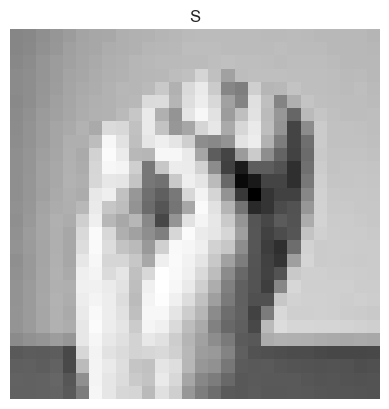

In [8]:
plt.imshow(X_train[10, 0], cmap = 'Greys_r')
plt.gca().set(title = f"{ALPHABET[y_train[10]]}")
no_ax = plt.gca().axis("off")

Let's look at a handful of images and their labels: 

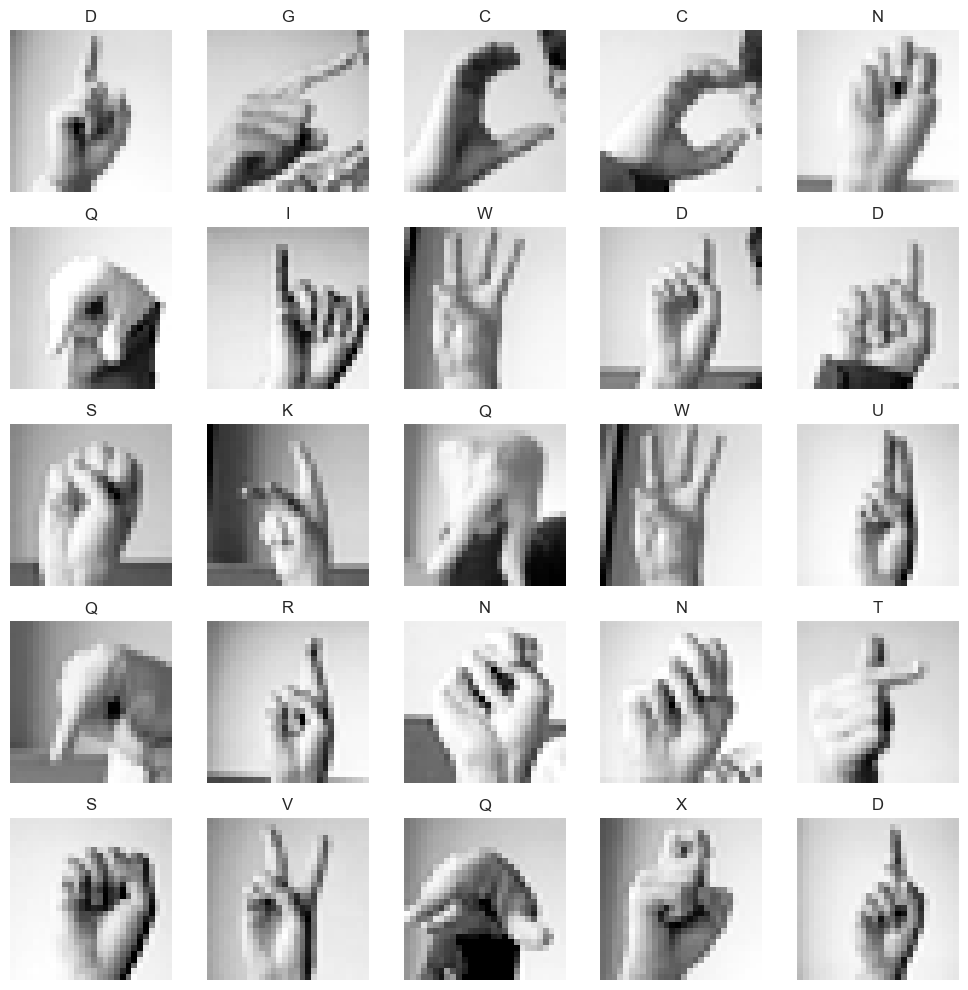

In [9]:
def show_images(X, y, rows, cols, channel = 0):

    fig, axarr = plt.subplots(rows, cols, figsize = (2*cols, 2*rows))
    for i, ax in enumerate(axarr.ravel()):
        ax.imshow(X[i, channel].detach(), cmap = "Greys_r")
        ax.set(title = f"{ALPHABET[y[i]]}")
        ax.axis("off")
    plt.tight_layout()

show_images(X_train, y_train, 5, 5)

How frequently does each letter appear in the data set? 

Let's look at the frequencies of each letter in this data set: [There are no "J"s or "Z"s in this data because these characters require motion rather than a static gesture.]{.aside}

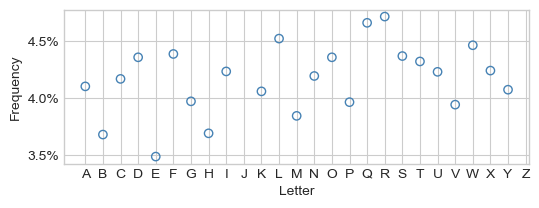

In [10]:
#| code-fold: true
fig, ax = plt.subplots(1, 1, figsize = (6, 2))
letters, counts = torch.unique(y_train, return_counts = True)
proportions = counts / counts.sum()
proportions

ax.scatter(letters, proportions*100, facecolor = "none", edgecolor = "steelblue")
ax.set_xticks(range(26))
ax.set_xticklabels(list(ALPHABET))
ax.set(xlabel = "Letter", ylabel = "Frequency")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 1))

- base rate is 5% because r is the letter that appears more

The most frequent letter ("R") in this data comprises no more than 5% of the entire data set. So, as a minimal aim, we would like a model that gets the right character at least 5% of the time. 

## First Approach: Pixel-By-Pixel Prediction

One simple way to vectorize our data would be to simply treat the greyscale value of each pixel as a feature. [This is actually the form our data came in: we are imagining that we were instead supplied with the images in rectangular form.]{.aside} This approach gives us a feature matrix in which each column corresponds to an individual pixel, of which are there are 784 in each image. 

In [11]:
X_train_flat = X_train.reshape(n, p) #n and p are numbers calculated earlier--> n is number of observations and p is num of pixels (28 x 28)
print(X_train_flat.size()) 

torch.Size([27455, 784])


Reshaping our square $28 \times 28$ images into long vectors of length $784 = 28^2$ is the only feature engineering step we need in this case. [Running this code on your laptop may lead to `ConvergenceWarnings` in logistic regression. For the purposes of following along with the notes it's ok to ignore these, although it's also possible to adjust the optimization algorithm or maximum number of iterations in `LogisticRegression` in order to make them go away.]{.aside}

In [13]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
f = LR.fit(X_train_flat, y_train)

How did we do on the training data?

In [14]:
LR.score(X_train_flat, y_train)

0.9581861227463121

Wow, that's a high accuracy for just going pixel-by-pixel! It almost seems too good to be true...

In [15]:
n_test = df_test.shape[0]
X_test_flat = X_test.reshape(n_test, p)
LR.score(X_test_flat, y_test)

0.6740100390407139

Indeed, we did much worse on the test data, with dramatic overfitting. That said, our model has still learned considerable pattern in the data: random guessing would lead to test accuracy in the range of 4-5%. 

The following function wraps up this experiment for convenient reuse down the line. The only addition is the incorporation of a `pipeline` function, which is going to reflect our later vectorization workflows. 

In [16]:
def vectorization_experiment(pipeline = lambda x: x, return_confusion_matrix = False):
    X_train_transformed = pipeline(X_train)
    X_train_flat = X_train_transformed.flatten(start_dim = 1)
    print(f"Number of features = {X_train_flat.size(1)}")

    LR = LogisticRegression() 
    LR.fit(X_train_flat, y_train)
    print(f"Training accuracy = {LR.score(X_train_flat, y_train):.2f}")

    X_test_transformed = pipeline(X_test) 
    X_test_flat = X_test_transformed.flatten(start_dim = 1)
    print(f"Testing accuracy  = {LR.score(X_test_flat, y_test):.2f}")

    if return_confusion_matrix: 
        y_test_pred = LR.predict(X_test_flat)
        return confusion_matrix(y_test, y_test_pred, normalize = "true")

In [17]:
vectorization_experiment() # same experiment as above

Number of features = 784
Training accuracy = 0.96
Testing accuracy  = 0.67


## Convolutional Kernels

A common approach to vectorization of images is to apply a *convolutional kernel*. [Convolutional kernels are not related in any way to positive-definite kernels.]{.aside} A convolutional kernel is a component of a vectorization pipeline which is specifically suited to the structure of images. In particular, *images are fundamentally spatial*. We might want to construct data features which reflect not just the value of an individual pixel, but also the values of pixels nearby that one. 

One of the most common types of layers is a *convolutional* layer. The idea of an image convolution is pretty simple. We define a square *kernel matrix* containing some numbers, and we "slide it over" the input data. At each location, we multiply the data values by the kernel matrix values, and add them together. Here's an illustrative diagram:

![](https://d2l.ai/_images/correlation.svg)

*Image from [Dive Into Deep Learning](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)*

In this example, the value of 19 is computed as $0\times 0 + 1\times 1 + 3\times 2 + 4\times 3 = 19$. 

Let's create some simple $5\times 5$ kernels that we'll apply to this image data. Our first one is designed to detect vertical lines in images: 

In [19]:
vertical = torch.tensor([0, 0, 5, 0, 0,]).repeat(5, 1) - 1.0
vertical

tensor([[-1., -1.,  4., -1., -1.],
        [-1., -1.,  4., -1., -1.],
        [-1., -1.,  4., -1., -1.],
        [-1., -1.,  4., -1., -1.],
        [-1., -1.,  4., -1., -1.]])

Let's make some more kernels for horizontal and vertical lines: 

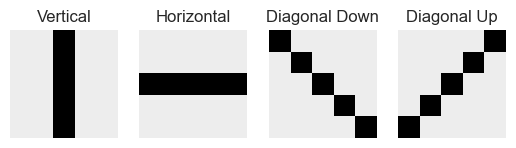

In [20]:
diag1    = torch.eye(5)*5 - 1
horizontal = torch.transpose(vertical, 1, 0)
diag2    = diag1.flip(1)

fig, ax = plt.subplots(1, 4)
for i, kernel in enumerate([vertical, horizontal, diag1, diag2]):
    ax[i].imshow(kernel, vmin = -1.5, vmax = 2)
    ax[i].axis("off")
    ax[i].set(title = f'{["Vertical", "Horizontal", "Diagonal Down", "Diagonal Up"][i]}')

Now let's make a function which will *apply* these convolutional kernels to our images. The output of each kernel will be stored as a separate *channel* of the image. 

In [21]:
def apply_convolutions(X): 

    # this is actually a neural network layer -- we'll learn how to use these
    # in that context soon 
    conv1 = Conv2d(1, 4, 5)

    # need to disable gradients for this layer
    for p in conv1.parameters():
        p.requires_grad = False

    # replace kernels in layer with our custom ones
    conv1.weight[0, 0] = Parameter(vertical)
    conv1.weight[1, 0] = Parameter(horizontal)
    conv1.weight[2, 0] = Parameter(diag1)
    conv1.weight[3, 0] = Parameter(diag2)

    # apply to input data and disable gradients
    return conv1(X).detach()

Now we're ready to compute the result of applying our kernels to the data. 

In [22]:
X_train_convd = apply_convolutions(X_train)

We now have a training data set of diffferent size. There's one channel (2nd index) for each of the four kernels we've applied. 

In [23]:
X_train_convd.size()
# same number of pics, 4 channels (not RGB colors, just one for each kernel) (4 processed images), 24 x 24 size --> smaller bc padding made image smaller

torch.Size([27455, 4, 24, 24])

Let's take a look at how each of the four kernels act on some images. 

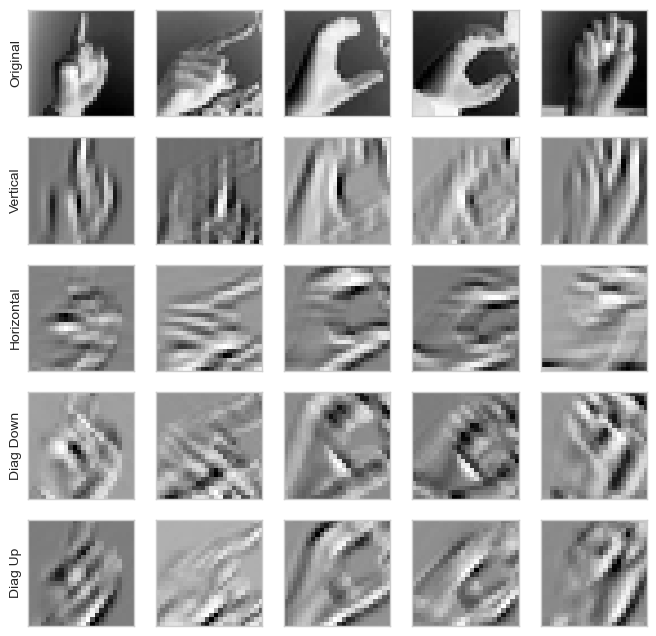

In [24]:
def kernel_viz(pipeline):

    fig, ax = plt.subplots(5, 5, figsize = (8, 8))

    X_convd = pipeline(X_train)

    for i in range(5): 
        for j in range(5):
            if i == 0: 
                ax[i,j].imshow(X_train[j, 0])
            
            else: 
                ax[i, j].imshow(X_convd[j,i-1])
            
            ax[i,j].tick_params(
                        axis='both',      
                        which='both',     
                        bottom=False,     
                        left=False,
                        right=False,         
                        labelbottom=False, 
                        labelleft=False)
            ax[i,j].grid(False)
            ax[i, 0].set(ylabel = ["Original", "Vertical", "Horizontal", "Diag Down", "Diag Up"][i])

kernel_viz(apply_convolutions)

We see that the Vertical kernel, for example, tends to accentuate vertical boundaries between light and dark in the images. The horizontal kernel accentuates horizontal boundaries, and so on. 

Ok, so we have Done Something to our images. Does this actually lead to better classification accuracy when we use logistic regression? 

In [25]:
vectorization_experiment(apply_convolutions) #more features bc more images

Number of features = 2304
Training accuracy = 1.00
Testing accuracy  = 0.53


Uhhhhh, well that actually seems to have made it worse. Somehow, we've actually overfit even more! One reason for this is that we have actually *increased* the number of features, without adding more data points. But shouldn't we have gotten a bump from having these purportedly useful features in the mix? 

Surprisingly, no. The reason is that kernel convolution is a fundamentally linear operation -- it's just a matter of multiplying the data by constants and adding the results together. Logistic regression is a linear model, and the way it calculates the score is *also* a linear operation. As you may remember, the result of doing two linear operations back-to-back is simply a different linear operation. But since everything involved is linear, our vectorization approach hasn't really added anything to the expressive power of logistic regression -- only add more feature columns to enable even greater overfitting. 

## Nonlinearity

In order to add to the expressive power of logistic regression, we need to do something *nonlinear* to the result of applying our convolutions. A common choice is the rectified linear unit, or ReLU. This very simple nonlinear function looks like this: 

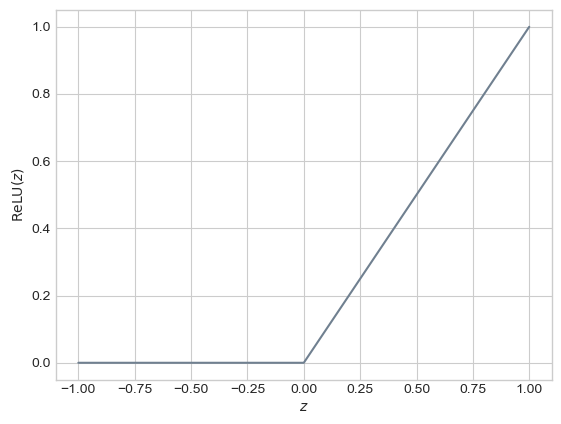

In [26]:
z = torch.linspace(-1, 1, 101)
f = relu(z)
plt.plot(z, f, color = "slategrey")
labs = plt.gca().set(xlabel = r"$z$",ylabel = r"$\mathrm{ReLU}(z)$")

Yes, it's just two linear functions pasted together, but that makes it technically nonlinear! The effect of applying the relu transformation on our convolved images is that pixels with negative values in each channel are set to 0. 

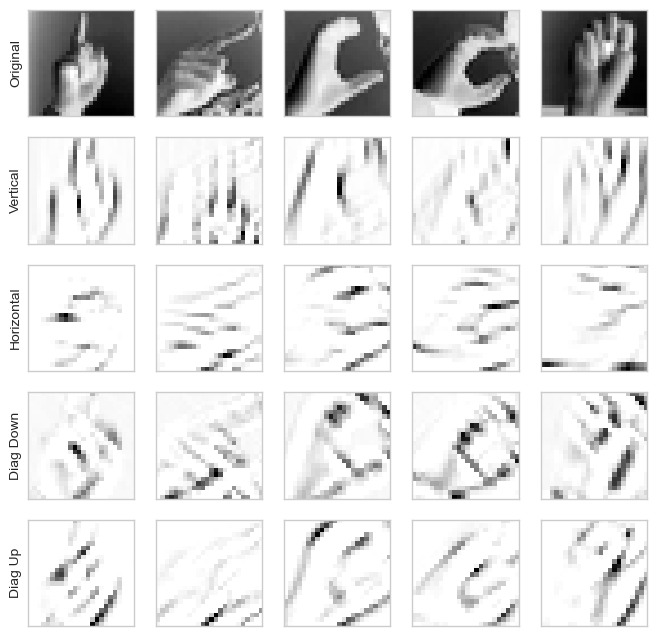

In [27]:
pipeline = lambda x: relu(apply_convolutions(x))
kernel_viz(pipeline)

Does setting a bunch of the pixels to 0 really help that much? Surprisingly, yes! Just applying this nonlinear transformation to our convolved images already significantly improves the classification power of our model on the test set. 

In [28]:
vectorization_experiment(pipeline)

Number of features = 2304
Training accuracy = 1.00
Testing accuracy  = 0.75


## Pooling

However, we do still have that very large number of features, which slows down model fitting and raises overfitting issues. To address this, let's *reduce* the data in a nonlinear way. We'll do this with max pooling. You can think of it as a kind of "summarization" step in which we intentionally make the current output somewhat "blockier." Technically, it involves sliding a window over the current batch of data and picking only the largest element within that window. Here's an example of how this looks:

![](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)

*Image credit: Computer Science Wiki*

A useful effect of pooling is that it reduces the number of features in our data. In the image above, we reduce the number of features by a factor of $2\times 2 = 4$. We can be even more aggressive than this: we'll reduce our data resolution by a factor of 16. 

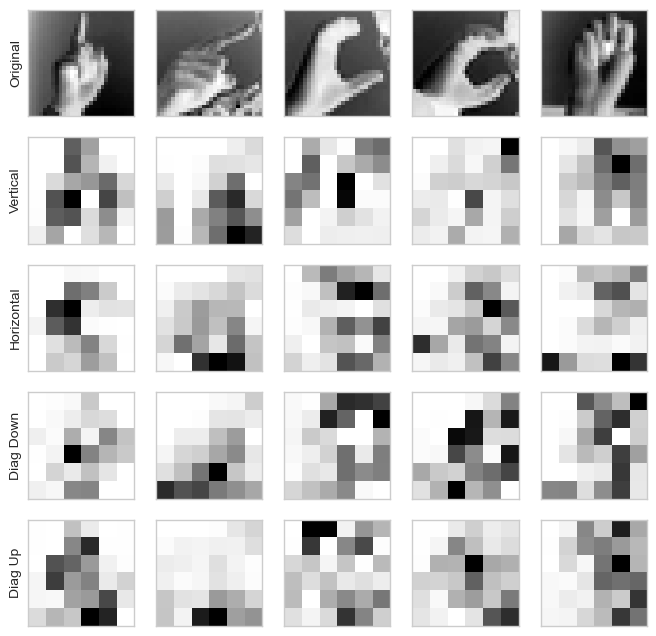

In [30]:
pipeline = lambda x: MaxPool2d(4, 4)(relu(apply_convolutions(x))) #for every 4x4 we replace it with one
kernel_viz(pipeline)

Our data now looks a lot chunkier, and doesn't really resemble recognizable hands at all. Surprisingly, however, this is another *big* improvement on our modeling power. 

In [31]:
vectorization_experiment(pipeline)

Number of features = 144
Training accuracy = 1.00
Testing accuracy  = 0.85


What we found overall in this process: 

5% - base rate

67% - pixel by pixel

54% - kernel convolution

75% - kernel convolution and ReLu

85% - kernel convolution and ReLu and maxPooling

Relative to the previous experiments, we have about 6% as many features to feed into our logistic regression models, which leads to a big speed-up. Despite this, the testing accuracy has gone considerably! We have managed to extract *useful*, vectorized features from our image-structured data set. [This level of accuracy is not enough to be practically useful. We'll later see how to do better on this data set.]{.aside}

## Other Kinds of Vectorization

Our pipeline above: convolutional kernels, pooling, and flattening, is an extremely common vectorization/feature engineering pipeline for image data. Indeed, it is at the foundation of *convolutional neural networks*, which are one of the standard ways for performing image classification. We'll work with convolutional neural networks later in these notes. How do we vector other data?

**Text** is often vectorized in one of two paradigms. 

1. In classical text analysis, it is common to form a *document-term matrix* in which the rows correspond to a given body of text (say, a single chapter of a book) and the columns correspond to words. The document-term matrix collects information on how frequently a given word appears in a given body of text. Various normalizations are possible. This kind of vectorization is common in sentiment analysis and topic modeling applications. 
2. In modern generative applications, we often represent bodies of text as sequences of words. Each word in the sequence is assigned a *vector* which is intended to represent the semantic content of the word in some way. A sequence of words is then a sequence of vectors in this vector space. The problem of finding good vectors to represent words is known as *word embedding* and is fundamental to a number of text-based tasks in modern deep learning. 

**Audio** is often vectorized using classical tools from signal processing, including (discrete) Fourier transforms and wavelet transforms. 
